In [77]:
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as  mpatches
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import normalize
import seaborn as sns

warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

from soma.generators.eye import EyeGenerator
from soma.tests import som_test

In [2]:
plot_dir = os.path.expanduser('~/Plots')
os.makedirs(plot_dir, exist_ok=True)

In [3]:
generators = dict(
    C=EyeGenerator('C'),
    I=EyeGenerator('I'),
    R=EyeGenerator('R'),
)

In [4]:
sample_size = 2000

In [5]:
isample = normalize(generators['I'].sample(sample_size))
csample = normalize(generators['C'].sample(sample_size))

In [6]:
p, som, (count_i, count_c) = som_test(isample, csample, ret_som=True, ret_counts=True, size=(40, 50))
p

0.0

In [7]:
attrs = ["fixcount", "firstPassCnt", "P1stFixation", "P2stFixation", "prevFixDur", "firstfixDur", "firstPassFixDur",
         "nextFixDur", "firstSaccLen", "lastSaccLen", "prevFixPos", "landingPos", "leavingPos", "totalFixDur",
         "meanFixDur", "nRegressFrom", "regressLen", "nextWordRegress", "regressDur", "pupilDiamMax", "pupilDiamLag",
         "timePrtctg"]
len(attrs)

22

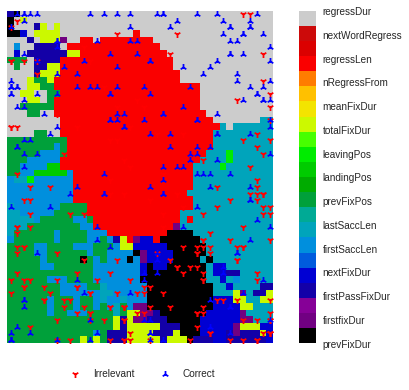

In [8]:
plt.figure()
plt.grid(False)
cmap = cm.get_cmap("nipy_spectral", 22)
plt.imshow(som.codebook.argmax(axis=-1), cmap=cmap)
plt.colorbar(ticks=np.arange(len(attrs)), format=plt.FuncFormatter(lambda val, loc: attrs[val]))

ibmus = som.get_bmus(som.get_surface_state(isample[np.random.choice(len(isample), 200)]))
plt.scatter(ibmus[:, 0], ibmus[:, 1], label='Irrelevant', marker='1', color='red')
cbmus = som.get_bmus(som.get_surface_state(csample[np.random.choice(len(csample), 200)]))
plt.scatter(cbmus[:, 0], cbmus[:, 1], label='Correct', marker='2', color='blue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

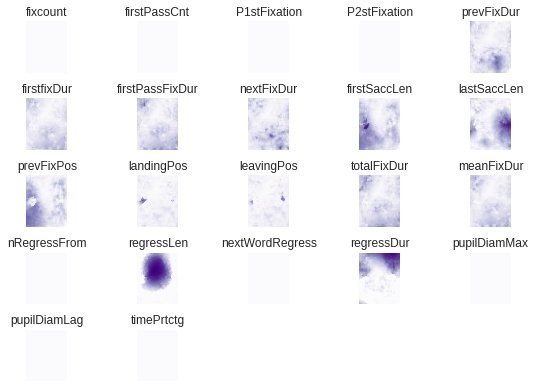

In [67]:
fig, axes = plt.subplots(ncols=5, nrows=5, sharex=True, sharey=True)

vmin = som.codebook.min()
vmax = som.codebook.max()

for i, ax in enumerate(axes.ravel()):
    if i < 22:
        ax.set_title(attrs[i])
        ax.imshow(som.codebook[:, :, i], cmap='Purples', vmin=vmin, vmax=vmax)

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')

#plt.subplots_adjust(hspace=0.8, wspace=0.01, bottom=0, top=1)
plt.tight_layout(w_pad=0)
plt.savefig('/home/aalvarez/Plots/eye_features.eps', bbox_inches='tight')

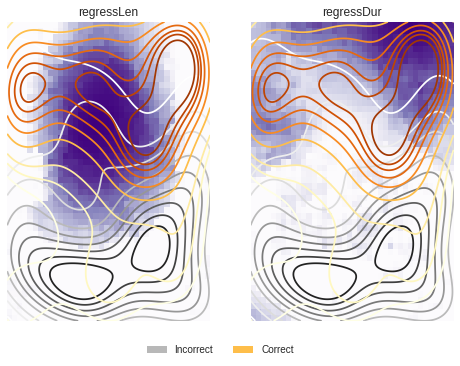

In [81]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

sns.heatmap(som.codebook[:, :, 16], cmap='Purples', ax=axes[0], cbar=False)
sns.heatmap(som.codebook[:, :, 18], cmap='Purples', ax=axes[1], cbar=False)
sns.kdeplot(ibmus[:, 0], ibmus[:, 1], ax=axes[0], fill=False, clip=((0,40),(0,50)), cmap='Greys', label='Incorrect')
sns.kdeplot(cbmus[:, 0], cbmus[:, 1], ax=axes[0], fill=False, clip=((0,40),(0,50)), cmap='YlOrBr', label='Correct')
sns.kdeplot(ibmus[:, 0], ibmus[:, 1], ax=axes[1], fill=False, clip=((0,40),(0,50)), cmap='Greys', label='Incorrect')
sns.kdeplot(cbmus[:, 0], cbmus[:, 1], ax=axes[1], fill=False, clip=((0,40),(0,50)), cmap='YlOrBr', label='Correct')

axes[0].set_title(attrs[16])
axes[1].set_title(attrs[18])
handles = [mpatches.Patch(facecolor=plt.cm.Greys(100), label="Incorrect"),
           mpatches.Patch(facecolor=plt.cm.YlOrBr(100), label="Correct")]
axes[1].legend(loc='upper center', bbox_to_anchor=(-0.15, -0.05), ncol=2, handles=handles)

axes[0].set_xticks([])
axes[0].set_yticks([])

plt.savefig('/home/aalvarez/Plots/eye_regress.eps', bbox_inches='tight')
plt.show()

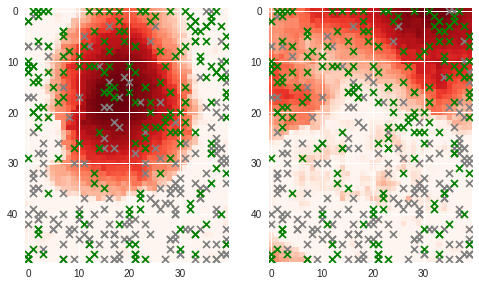

In [15]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(som.codebook[:, :, 16], cmap='Reds')
axes[1].imshow(som.codebook[:, :, 18], cmap='Reds')

for ax in axes:
    ax.scatter(ibmus[:, 0], ibmus[:, 1], marker='x', color='gray', label='Irrelevant')
    ax.scatter(cbmus[:, 0], cbmus[:, 1], marker='x', color='green', label='Correct')

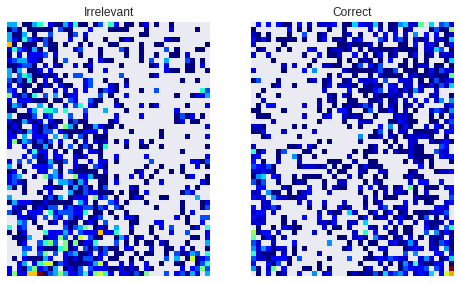

In [116]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(np.ma.masked_where(count_i == 0, count_i), cmap='jet')
axes[0].set_title('Irrelevant')
axes[1].imshow(np.ma.masked_where(count_c == 0, count_c), cmap='jet')
axes[1].set_title('Correct')
for ax in axes:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [117]:
from sklearn.base import BaseEstimator, ClassifierMixin


class SOMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, size=(20, 15)):
        super(SOMWrapper, self).__init__()
        self.__size = size
        self.__p = None
        self.__som = None
        self.__class = None

    def get_params(self, deep: bool = False):
        return {'size': self.__size}

    def set_params(self, size):
        self.__size = size

    def fit(self, X, y):
        self.__p, self.__som, (count1, count2) = som_test(X[y == 0], X[y == 1], ret_counts=True, ret_som=True,
                                                          size=self.__size)
        self.__class = (count2 > count1).astype(int).T
        return self

    def predict(self, X):
        bmus = self.__som.get_bmus(self.__som.get_surface_state(X))
        return self.__class[bmus[:, 0], bmus[:, 1]]

In [118]:
kfold = KFold(n_splits=50, random_state=None, shuffle=True)
sample_size = 2500  # So the training is done on roughly 400 per class

In [119]:
import itertools

pairwise = list(itertools.combinations(generators.keys(), 2))

for a, b in pairwise:
    sample_a = normalize(generators[a].sample(sample_size))
    sample_b = normalize(generators[b].sample(sample_size))

    X = np.concatenate([sample_a, sample_b])
    y = np.repeat([0, 1], sample_size)

    scores = cross_val_score(SOMWrapper(size=(20, 15)), X, y, scoring='accuracy', cv=kfold, n_jobs=3,
                             error_score='raise')
    print(a, b, np.mean(scores), np.std(scores))

C I 0.7247999999999999 0.06000799946673777
C R 0.6847999999999999 0.04871303726929783
I R 0.5760000000000001 0.04669047011971501
